In [1]:
# This notebook is used for testing learning using the sirasi module.

# In particular, extracting the eigenvectors of the input correlation matrix.
# The algorithm used is based on Foldiak (1989) "Adaptive network for optimal linear feature extraction"
# Proc IEEE/INNS IJCNN 1:401-405

# By Sergio Verduzco Flores        June 2017

In [2]:
from sirasi import *
import numpy as np
import pylab
import time
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
def conn_mat(net):
    # Get the connection matrix of a network in a Numpy array
    conns = np.zeros((net.n_units,net.n_units))
    for syn_list in net.syns:
        for syn in syn_list:
            conns[syn.postID,syn.preID] = syn.w
    return conns

def plot_stuff(data):
    #fig.clf()
    #plt.close()
    fig = plt.figure(figsize=(10,6))
    for i in range(9):
        ax = fig.add_subplot(3,3,i+1)
        ax.clear()
        plt.ylim(-0.01,0.5)
        ax.plot(data[0], data[1][i], 'r', figure=fig)
    new_fig = plt.figure(figsize=(5,3))
    plt.plot(sim_dat[0], sim_dat[1][9], 'b', sim_dat[0], sim_dat[1][10], 'k', figure=new_fig)
    plt.plot(sim_dat[0], sim_dat[1][11], 'g', sim_dat[0], sim_dat[1][12], 'r', figure=new_fig)
    fig.canvas.draw()
    plt.show()
    

In [4]:
################# TEST 1 ####################
######### 1) Create a network
net_params = {'min_delay' : 0.1, 'min_buff_size' : 4 } # parameter dictionary for the network
n1 = network(net_params)

######### 2) Put some units in the network
# parameters for the units
n_units = 8
init_val_list = np.random.uniform(0.2, 0.6, n_units) # initial values for the non-source units
slope_list = np.random.uniform(0.8, 2. ,n_units) # slopes for sigmoidal units
thresh_list = np.random.uniform(-0.1, 0.2, n_units)  #thresholds for sigmoidal units
tau_list = np.random.uniform(0.04, 0.1, n_units)
pars = { 'coordinates' : (0., 0., 0.),
         'delay' : .1, 'init_val' : 0.5, 'tau_fast' : 1.,
         'type' : unit_types.source }  # TODO: It's silly to initialize units with 'delay'
inputs = n1.create(9,pars) # creating nine input sources
pars = { 'coordinates' : (0., 0., 0.),
         'delay' : .1, 'init_val' : init_val_list, 'tau_fast' : 1.,
         'slope' : slope_list, 'thresh' : thresh_list, 'tau' : tau_list,
         'type' : unit_types.sigmoidal } 
units = n1.create(n_units,pars) # creating sigmoidal units

######### 3) Connect the units in the network
conn_spec = {'rule' : 'all_to_all', 
             'delay' : {'distribution' : 'uniform', 'low' : 0.3, 'high' : 0.6},
             'allow_autapses' : False} # connection specification dictionary
syn_pars = {'init_w' : {'distribution':'uniform', 'low':0.1, 'high':0.5}, 
            'lrate' : 0.02, 'type' : synapse_types.oja} # synapse parameters dictionary
n1.connect(inputs, units, conn_spec, syn_pars)

# We put anti-Hebbian learning in the units to see if they can learn to extract different features
syn_pars['init_w'] = 0.
syn_pars['lrate'] = 0.05
syn_pars['type'] = synapse_types.antihebb
n1.connect(units, units, conn_spec, syn_pars)

######### 4) Running and visualizing 

####### SETTING THE INPUT FUNCTIONS
### You are going to present 4 input patterns that randomly switch over time.
### Imagine the 9 inputs arranged in a grid, like a tic-tac-toe board, numbered
### from left to right and from top to bottom:
### 1 2 3
### 4 5 6
### 7 8 9
### You'll have input patterns
### 0 X 0   0 0 0   X 0 X   0 X 0
### 0 X 0   X X X   0 0 0   X 0 X
### 0 X 0   0 0 0   X 0 X   0 X 0
### The input is always a normalized linear combination of one or two of these patterns.
### Pattern pat1 is presented alone for t_pat time units, and then there is a transition period
### during which pat1 becomes pat2 by presenting at time t an input 
### c*(t_pat+t_trans - t)*pat1 + c*(t - tpat)*pat2
### where c = 1/t_trans, and t_trans is the duration of the transition period. 
### At time t_pat+t_trans, pat2 is presented by itself for t_pat time units.
### 
# here are the patterns as arrays
patterns = [np.zeros(9) for i in range(4)]
patterns[0] = np.array([0., 1., 0., 0., 1., 0., 0., 1., 0.])/3.
patterns[1] = np.array([0., 0., 0., 1., 1., 1., 0., 0., 0.])/3.
patterns[2] = np.array([1., 0., 1., 0., 0., 0., 1., 0., 1.])/4.
patterns[3] = np.array([0., 1., 0., 1., 0., 1., 0., 1., 0.])/4.

n_pres = 30
# number of times some pattern will be presented
t_pat = 5. # as above
t_trans = 2.
c = 1/t_trans # auxiliary variable
pats = range(4) # auxiliary variable
cur_pat = np.random.choice(pats)  # pattern currently presented
next_pat = np.random.choice(pats) # next pattern to be presented
last_t = 0.
start_time = time.time()

def make_fun1(idx):  
    # This creates a constant function with value: patterns[cur_pat][idx]
    # thus avoiding a scoping problem that is sometimes hard to see:
    # https://eev.ee/blog/2011/04/24/gotcha-python-scoping-closures/
    fun = lambda t : patterns[cur_pat][idx]
    return fun

def make_fun2(idx, last_t):
    # Creates a function for the pattern transition
    fun = lambda t : c * ( (t_trans - (t-last_t))*patterns[cur_pat][idx] +
                           (t-last_t)*patterns[next_pat][idx] )
    return fun

for pres in range(n_pres):
# For each cycle you'll set the input functions and simulate, once with a single pattern,
# once with a mix of patterns, as described above
    
    # first, we present a single pattern
    for u in range(9):
        n1.units[inputs[u]].set_function( make_fun1(u) )
        
    sim_dat = n1.run(t_pat)  # simulating
    last_t = n1.sim_time # simulation time after last pattern presentation
    
    #plot_stuff(sim_dat)
    #input('Fixed pattern presented: ' + str(cur_pat))
    
    # now one pattern turns into the next
    for u in range(9):
        n1.units[inputs[u]].set_function(make_fun2(u, last_t))
    
    sim_dat = n1.run(t_trans) # simulating
    
    #plot_stuff(sim_dat)
    #input('Transitioned to pattern: ' + str(next_pat))

    # choose the pattern you'll present next
    cur_pat = next_pat
    next_pat = np.random.choice(pats)
    
    if pres%10 == 0:
        print('Presentation ' + str(pres+1))

print('Execution time: %s seconds' % (time.time() - start_time))


Presentation 1
Presentation 11
Presentation 21
Execution time: 224.08278465270996 seconds


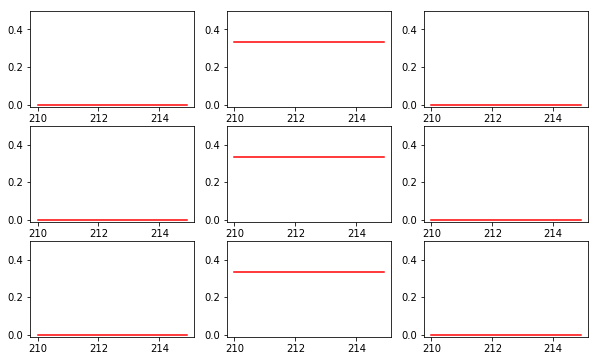

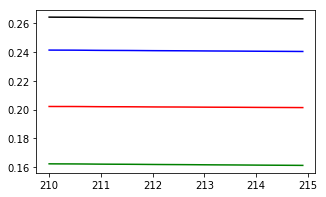

Fixed pattern presented: 0


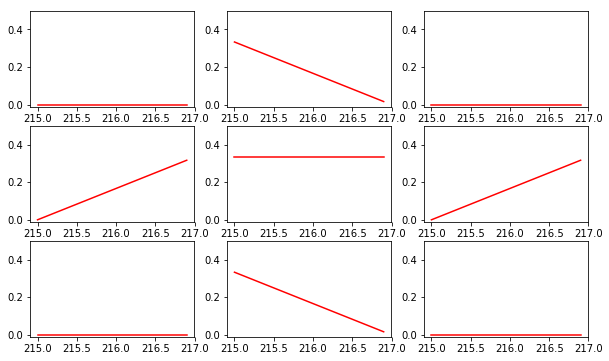

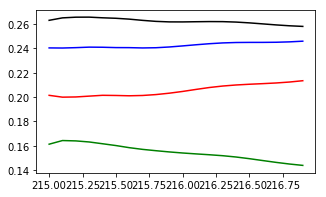

Transitioned to pattern: 1
Presentation 1


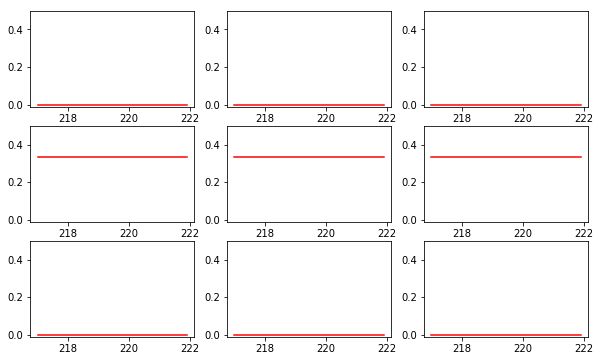

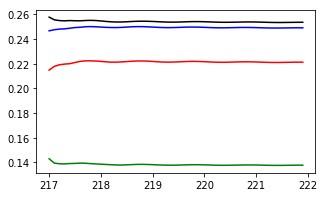

Fixed pattern presented: 1


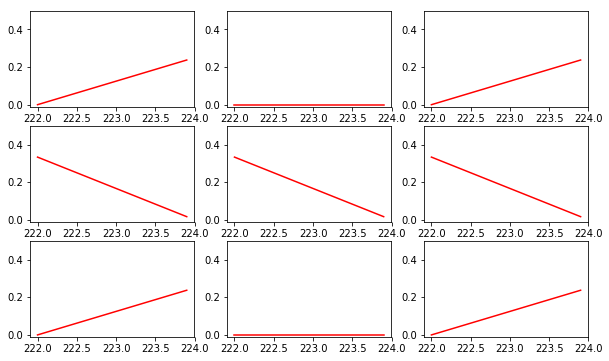

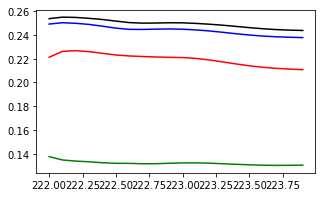

Transitioned to pattern: 2


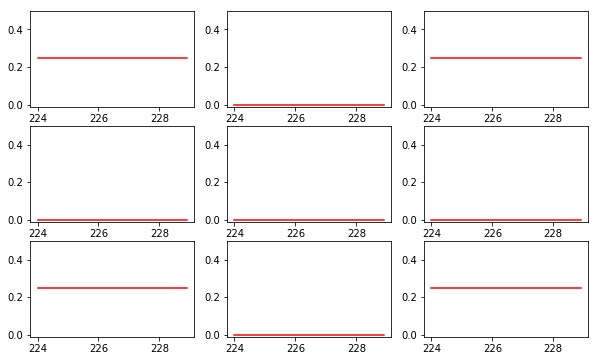

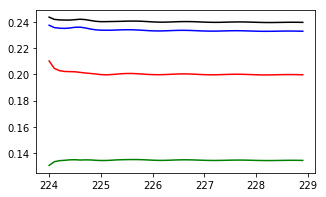

Fixed pattern presented: 2


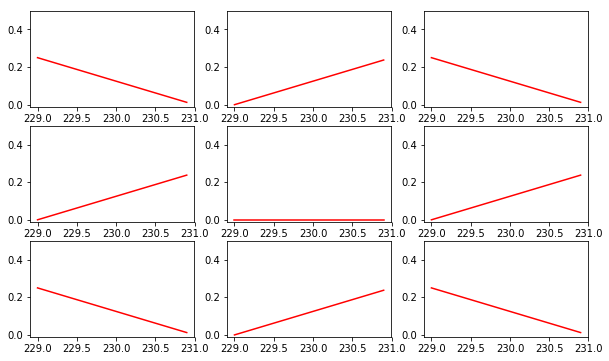

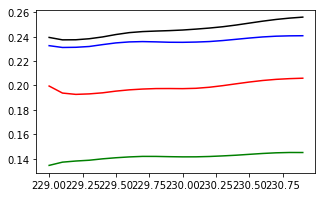

Transitioned to pattern: 3


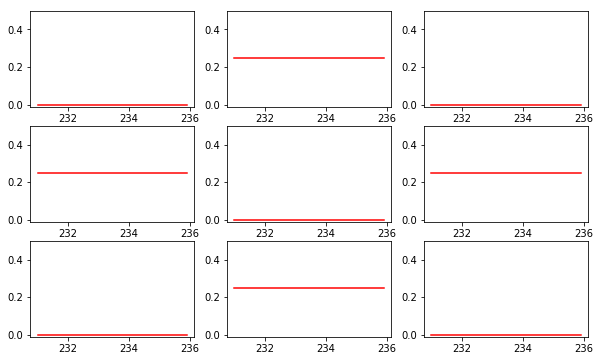

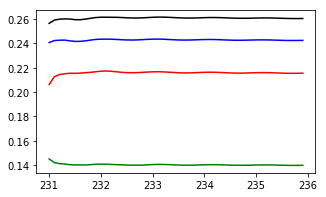

Fixed pattern presented: 3


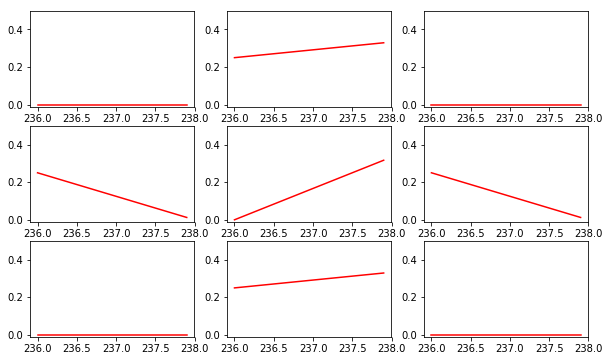

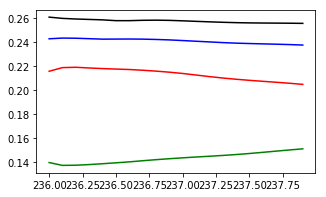

Transitioned to pattern: 0
['0.32', '0.38', '0.27', '0.36']
['0.37', '0.36', '0.26', '0.40']
['0.38', '0.31', '0.27', '0.33']
['0.29', '0.39', '0.27', '0.38']
['0.34', '0.35', '0.26', '0.34']
['0.38', '0.35', '0.28', '0.33']
['0.35', '0.39', '0.32', '0.31']
['0.29', '0.31', '0.39', '0.33']


In [5]:
# Checking whether the units have preferred patterns

n_pres = 4
cur_pat = 0
next_pat = 1
for pres in range(n_pres):
# For each cycle you'll set the input functions and simulate, once with a single pattern,
# once with a mix of patterns, as described above
    
    # first, we present a single pattern
    
    for u in range(9):
        n1.units[inputs[u]].set_function( make_fun1(u) )
        
    sim_dat = n1.run(t_pat)  # simulating
    last_t = n1.sim_time # simulation time after last pattern presentation
    
    plot_stuff(sim_dat)
    input('Fixed pattern presented: ' + str(cur_pat))
    
    # now one pattern turns into the next
    for u in range(9):
        n1.units[inputs[u]].set_function(make_fun2(u, last_t))
    
    sim_dat = n1.run(t_trans) # simulating
    
    plot_stuff(sim_dat)
    input('Transitioned to pattern: ' + str(next_pat))

    # choose the pattern you'll present next
    cur_pat = next_pat
    next_pat = (next_pat+1)%4
    
    if pres%10 == 0:
        print('Presentation ' + str(pres+1))
        
        
weights = [ (np.array(n1.units[9+i].get_weights(n1.sim_time)))[0:9] for i in range(n_units)]
proj = [[] for i in range(n_units)]
for i in range(n_units):
    proj[i] = [sum(weights[i]*patterns[j]) for j in range(4)]
    print(["%.2f" % v for v in proj[i]])



Max eigenvalue: 0.602188329871, index: 2
['0.24', '0.34', '0.20', '0.45', '0.32', '0.36', '0.32', '0.30', '0.30']
['0.20', '0.43', '0.39', '0.42', '0.30', '0.35', '0.19', '0.39', '0.24']
['0.23', '0.27', '0.21', '0.23', '0.39', '0.31', '0.37', '0.48', '0.27']
['0.17', '0.28', '0.26', '0.46', '0.27', '0.46', '0.20', '0.33', '0.43']
['0.26', '0.42', '0.17', '0.30', '0.36', '0.40', '0.25', '0.23', '0.35']
['0.22', '0.32', '0.17', '0.34', '0.43', '0.29', '0.41', '0.38', '0.33']
['0.43', '0.32', '0.29', '0.33', '0.48', '0.36', '0.34', '0.24', '0.23']
['0.21', '0.21', '0.47', '0.48', '0.24', '0.21', '0.43', '0.44', '0.44']


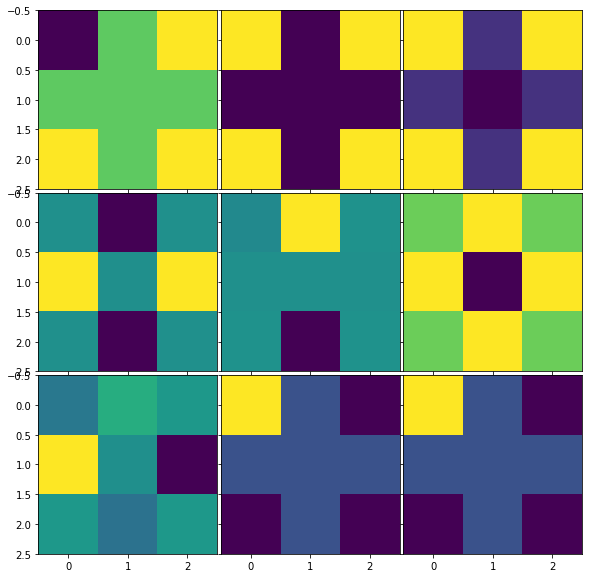

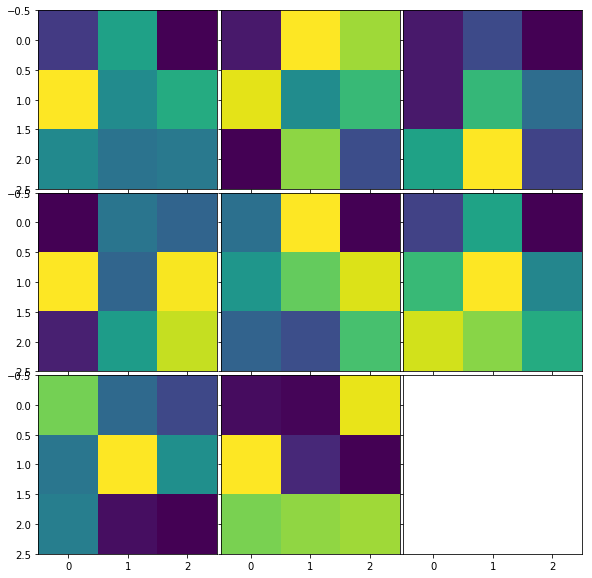

In [6]:
#### Comparing the weight vectors with the leading eigenvector of the correlation matrix
#######################################################################################

plt.ion()

# Obtaining eigenvectors of the correlation matrix
pat_mat = np.matrix(patterns)
corr = (pat_mat.T)*pat_mat # input correlation matrix
eigs = np.linalg.eig(corr) # extracting eigenvalues and eigenvectors
evals = eigs[0] # eigenvalues
evecs = [eigs[1][:,i] for i in range(9)] # eigenvectors

# obtaining the leading eigenvector
max_index, max_value = max(enumerate(evals), key=lambda p:p[1])
print('Max eigenvalue: ' + str(max_value) + ', index: ' + str(max_index))
max_evector = evecs[max_index]
    
# plotting all eigenvectors in 3x3 format
fig3 = plt.figure(figsize=(10,10))
ev_grid = ImageGrid(fig3, 111, nrows_ncols=(3,3), axes_pad=0.05)
for idx,vec in enumerate(evecs):
    vec.shape = 3,3
    ev_grid[idx].imshow(vec)

# plotting leading eigenvector VS weight vectors in 3x3 format
fig4 = plt.figure(figsize=(10,10))
cols = int(round(np.sqrt(n_units)))
if cols*cols < n_units:
    rows = cols + 1
else:
    rows = cols
sp_ev_grid = ImageGrid(fig4, 111, nrows_ncols=(rows,cols), axes_pad=0.05)
for idx,vec in enumerate(weights):
    vec.shape = 3,3
    sp_ev_grid[idx].imshow(vec)
    print(["%.2f" % float(v[0]) for v in vec.reshape(9,1)])


['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0

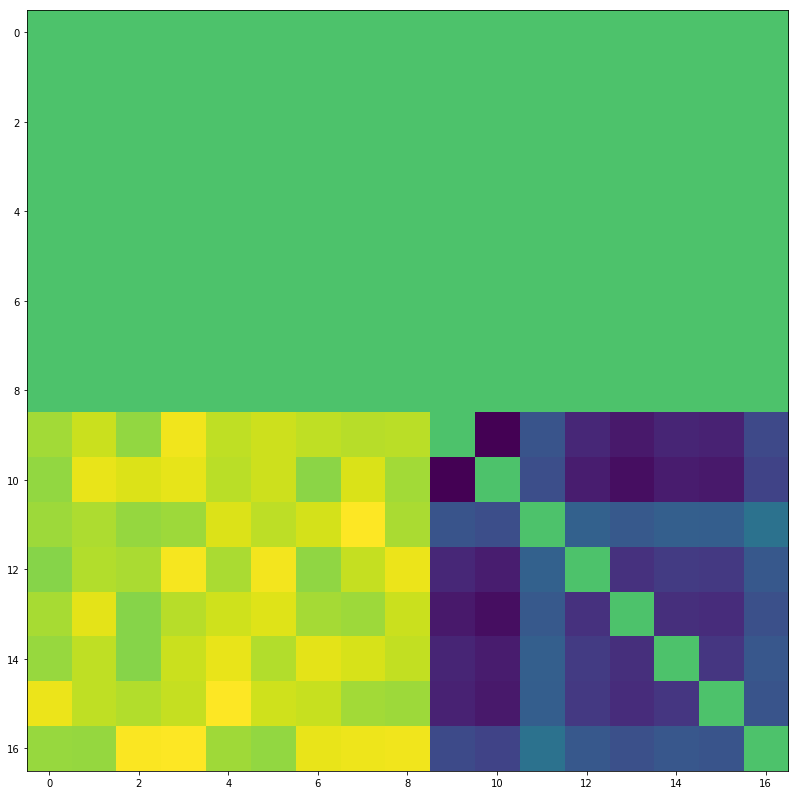

In [12]:
C = conn_mat(n1)
for row in C:
    print(["{0:0.1f}".format(i) for i in row])

fig5 = plt.figure(figsize=(14,14))
conn_grid = ImageGrid(fig5, 111, nrows_ncols=(1,1), axes_pad=0.2)
conn_grid[0].imshow(C)
#print(n1.delays)

In [8]:
for unit in n1.units:
    if unit.type == unit_types.sigmoidal:
        print('delay: %f' % unit.delay)
        print('init: %f' % unit.init_val)
        print('tau: %f' % unit.tau)
        print('thresh: %f' % unit.thresh)
        print('slope: %f' % unit.slope)
        print('')
        

delay: 0.700000
init: 0.224225
tau: 0.079791
thresh: -0.008794
slope: 1.039969

delay: 0.700000
init: 0.204500
tau: 0.095818
thresh: -0.064393
slope: 1.006936

delay: 0.600000
init: 0.587684
tau: 0.057923
thresh: 0.175589
slope: 1.900476

delay: 0.700000
init: 0.226702
tau: 0.084496
thresh: 0.125600
slope: 1.176133

delay: 0.700000
init: 0.597661
tau: 0.095978
thresh: 0.061970
slope: 1.070401

delay: 0.700000
init: 0.548914
tau: 0.044464
thresh: 0.125856
slope: 1.154456

delay: 0.700000
init: 0.569457
tau: 0.072732
thresh: 0.044788
slope: 1.250150

delay: 0.700000
init: 0.526689
tau: 0.096551
thresh: 0.048159
slope: 1.982631

